# Data visualization

This test allows us to corroborate the proper interpretation of the data of the spectral energy distributions coming from the active galaxies in the example.

## SED plots from example (AGNfitter v1.0)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
import astropy.constants as const
import scipy

In [2]:
# Cosmology thar we asume
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.266)

In [3]:
# Data format
# Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED = np.loadtxt("Examples/catalog_example.txt")

#Observed
z = 0.283                                                   # Redshift

f_obs = (3*1e8)/(SED[0, 2::3]*1e-10)                        # Observed frequency [Hz]
data_Jy = SED[0, 3::3]*u.Jy                                 # Intensity [Jy] 
data = data_Jy.to(u.erg/u.s/(u.cm)**2 /u.Hz).value          # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
D_L = cosmo.luminosity_distance(z).to(u.cm).value           # Relation distance-luminosity
flux =  f_obs*data*4*np.pi*(D_L)**2                         # Flux [erg s⁻¹]

# Uncertainty [erg s⁻¹]
error = f_obs*(SED[0, 4::3]*u.Jy).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L)**2 

# Rest frame frequency [Hz] 
f_rest = [i*(1+z) for i in f_obs] 

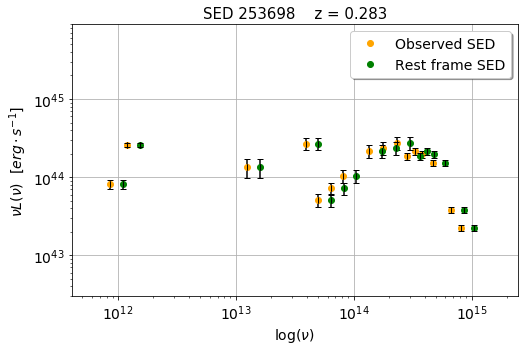

In [4]:
fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
plt.loglog(f_obs, flux,color = 'orange', marker = 'o', linestyle = '', label = 'Observed SED')
(_, caps, _) = plt.errorbar(f_obs,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.loglog(f_rest, flux, color = 'green', marker = 'o', linestyle = '', label = 'Rest frame SED')
(_, caps, _) = plt.errorbar(f_rest,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.grid() 
plt.title('SED 253698    z = ' + str(z), fontsize = 15)
plt.legend(fontsize = 14, shadow = True)
plt.ylim(3*1e42, 9*1e45)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

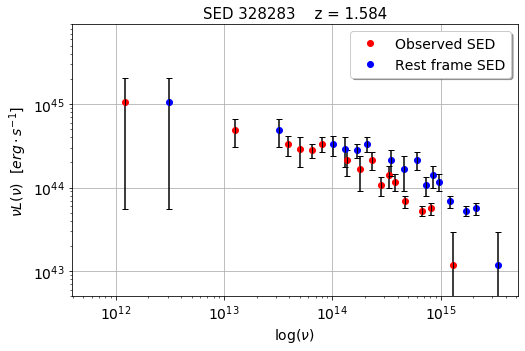

In [5]:
#Observed
z2 = 1.584                                                   # Redshift

f2_obs = (3*1e8)/(SED[1, 2::3]*1e-10)                        # Observed frequency [Hz]
data2_Jy = SED[1, 3::3]*u.Jy                                 # Intensity [Jy] 
data2 = data2_Jy.to(u.erg/u.s/(u.cm)**2 /u.Hz).value         # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
D_L2 = cosmo.luminosity_distance(z2).to(u.cm).value          # Relation distance-luminosity
flux2 =  f2_obs*data2*4*np.pi*(D_L2)**2                      # Flux [erg s⁻¹]

# Uncertainty [erg s⁻¹]
error2 = f2_obs*(SED[1, 4::3]*u.Jy).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L2)**2 

# Rest frame frequency [Hz] 
f2_rest = [i*(1+z2) for i in f2_obs] 


fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
plt.loglog(f2_obs, flux2,color = 'red', marker = 'o', linestyle = '', label = 'Observed SED')
(_, caps, _) = plt.errorbar(f2_obs,  flux2, yerr=  error2, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.loglog(f2_rest, flux2,color = 'blue', marker = 'o', linestyle = '', label = 'Rest frame SED')
(_, caps, _) = plt.errorbar(f2_rest,  flux2, yerr=  error2, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.grid() 
plt.title('SED 328283    z = ' + str(z2), fontsize = 15)
plt.legend(fontsize = 14, shadow = True)
plt.ylim(5*1e42, 9e45)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Plot of a telescope filter

Visualization of telescope filter:

In [6]:
# Subaru telescope transfer function (optical and IR)
Subaru_B = pd.read_csv("Filters/B_subaru.res", sep="  ", decimal=".", names = ['wl', 'I'], skiprows = 0, engine='python')

wl_SB = Subaru_B['wl']*10**(-1) # wavelength [nm]
I_SB = Subaru_B['I'] # Intensity

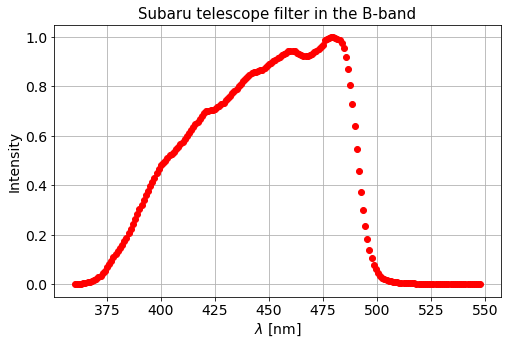

In [7]:
fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'Intensity', fontsize = 14) 
plt.xlabel(r'$\lambda$ [nm]', fontsize = 14) 
plt.plot(wl_SB, I_SB ,color = 'r', marker = 'o', linestyle = '')
plt.grid() 
plt.title('Subaru telescope filter in the B-band', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

Is valid the approximation of central wavelength in v_2.0?

In [8]:
# Data format
SPIRE250 = pd.read_csv("Filters/SPIRE_250mu.txt", delim_whitespace=True,  names = ['wl', 'I'], decimal=".", skiprows = 0)
SPIRE350 = pd.read_csv("Filters/SPIRE_350mu.txt", delim_whitespace=True,  names = ['wl', 'I'], decimal=".", skiprows = 0)
PACS100 = pd.read_csv("Filters/PACS_100mu.txt", delim_whitespace=True,  names = ['wl', 'I'], decimal=".", skiprows = 0)
MIPS70 = pd.read_csv("Filters/mips70.res", delim_whitespace=True,  names = ['wl', 'I'], decimal=".", skiprows = 9)

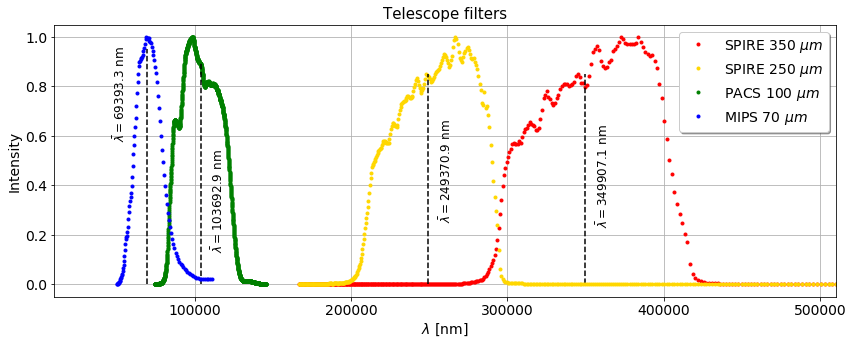

In [9]:
fig = plt.figure(figsize=(14, 5))
plt.ylabel(r'Intensity', fontsize = 14) 
plt.xlabel(r'$\lambda$ [nm]', fontsize = 14) 

plt.plot(SPIRE350['wl']*1e-1, SPIRE350['I'],color = 'r', marker = '.', linestyle = '', label = r'SPIRE 350 $\mu m$')
plt.plot([3499071*1e-1,3499071*1e-1],[0, 0.85],color ='black',  linewidth=1.5, linestyle="--")
plt.annotate(r'$\bar{\lambda} = 349907.1$ nm', xy=(3499071*1e-1, 0.2), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12, rotation = 90)

plt.plot(SPIRE250['wl']*1e-1, SPIRE250['I'],color = 'gold', marker = '.', linestyle = '', label = r'SPIRE 250 $\mu m$')
plt.plot([2493709*1e-1,2493709*1e-1],[0, 0.85],color ='black',  linewidth=1.5, linestyle="--")
plt.annotate(r'$\bar{\lambda} = 249370.9$ nm', xy=(2493709*1e-1, 0.22), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12, rotation = 90)

plt.plot(PACS100['wl']*1e-1, PACS100['I'] ,color = 'g', marker = '.', linestyle = '', label = r'PACS 100 $\mu m$')
plt.plot([1036929*1e-1,1036929*1e-1],[0, 0.90],color ='black',  linewidth=1.5, linestyle="--")
plt.annotate(r'$\bar{\lambda} = 103692.9$ nm', xy=(1036929*1e-1, 0.1), 
             xycoords='data',xytext=(+10, +10), textcoords='offset points', fontsize=12,  rotation = 90)

plt.plot(MIPS70['wl']*1e-1, MIPS70['I'],color = 'b', marker = '.', linestyle = '', label = r'MIPS 70 $\mu m$')
plt.plot([693933*1e-1,693933*1e-1],[0, 0.95],color ='black',  linewidth=1.5, linestyle="--")
plt.annotate(r'$\bar{\lambda} = 69393.3$ nm', xy=(693933*1e-1, 0.55), 
             xycoords='data',xytext=(-35, +10), textcoords='offset points', fontsize=12,  rotation = 90)

plt.grid() 
plt.title(r'Telescope filters', fontsize = 15)
plt.legend(fontsize = 14, shadow = True)
plt.xlim(1e4,5.1*1e5)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Plots of Brown data

In [10]:
# Data format
# Number, Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED_Brown_obs = pd.read_csv("Brown_data/brown2018_obs_agnfitter.txt", delim_whitespace=True, decimal=".", skiprows = 0)

The SEDs of the first 3 galaxies will be plotted.

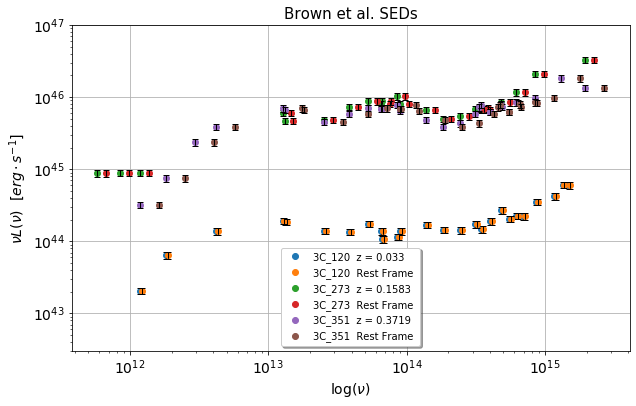

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 


for i in range(1, 4):
    z = SED_Brown_obs.iloc[i, 2]                                                # Redshift
    f_obs = (3*1e8)/(np.array(SED_Brown_obs.iloc[i, 3::3])*1e-6)                # Observed frequency [Hz]
    data_Jy = SED_Brown_obs.iloc[i, 4::3]*u.Jy*1e-3                             # Spectral flux density [Jy]
    data = np.array([i.to(u.erg/u.s/(u.cm)**2 /u.Hz).value for i in data_Jy])   # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
    D_L = cosmo.luminosity_distance(z).to(u.cm).value                           # Relation distance-luminosity
    flux =  f_obs*data*4*np.pi*(D_L)**2                                         # Flux [erg s⁻¹]
    
    # Uncertainty [erg s⁻¹]
    error = f_obs*np.array([(i*u.Jy*1e-3).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L)**2 for i in SED_Brown_obs.iloc[i, 5::3]])          
    name = SED_Brown_obs.iloc[i, 1]                                             # Source name
    
    # OBSERVED SED
    plt.loglog(f_obs, flux, marker = 'o', linestyle = '', label = str(name) + '  z = ' + str(round(z,4)))
    (_, caps, _) = plt.errorbar(f_obs,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    f_rest = f_obs*(1+z)                                           # Rest frame frequency [Hz]   
    
    # REST FRAME SED
    plt.loglog(f_rest, flux, marker = 'o', linestyle = '', label = str(name) + '  Rest Frame ')
    (_, caps, _) = plt.errorbar(f_rest,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
    for cap in caps:
        cap.set_markeredgewidth(1)
    
plt.grid() 
plt.title('Brown et al. SEDs', fontsize = 15)
plt.legend(fontsize = 10, shadow = True, loc=8)
plt.ylim(3*1e42, 1e47)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [12]:
# Data format
# Number, Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED_Brown_syn = pd.read_csv("Brown_data/brown2018_syn_agnfitter-2.txt", delim_whitespace=True, decimal=".", skiprows = 0)

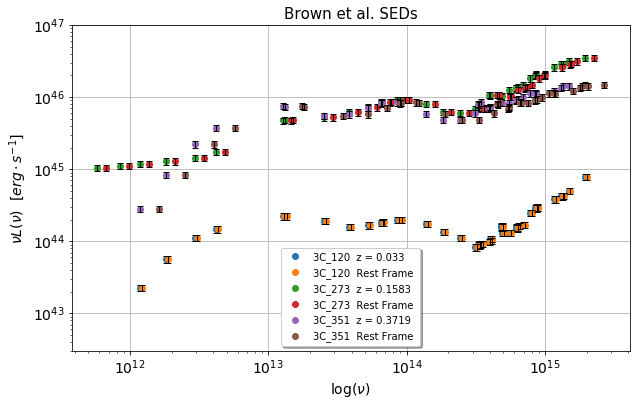

In [13]:
fig = plt.figure(figsize=(10, 6))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 


for i in range(1, 4):
    z = SED_Brown_syn.iloc[i, 2]                                                # Redshift
    f_obs = (3*1e8)/(np.array(SED_Brown_syn.iloc[i, 3::3])*1e-6)                # Observed frequency [Hz]
    data_Jy = SED_Brown_syn.iloc[i, 4::3]*u.Jy*1e-3                             # Spectral flux density [Jy]
    data = np.array([i.to(u.erg/u.s/(u.cm)**2 /u.Hz).value for i in data_Jy])   # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
    D_L = cosmo.luminosity_distance(z).to(u.cm).value                           # Relation distance-luminosity
    flux =  f_obs*data*4*np.pi*(D_L)**2                                         # Flux [erg s⁻¹]
    
    # Uncertainty [erg s⁻¹]
    error = f_obs*np.array([(i*u.Jy*1e-3).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L)**2 for i in SED_Brown_syn.iloc[i, 5::3]])          
    name = SED_Brown_syn.iloc[i, 1]                                             # Source name
    
    # OBSERVED SED
    plt.loglog(f_obs, flux, marker = 'o', linestyle = '', label = str(name) + '  z = ' + str(round(z,4)))
    (_, caps, _) = plt.errorbar(f_obs,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    f_rest = f_obs*(1+z)                                           # Rest frame frequency [Hz]   
    
    # REST FRAME SED
    plt.loglog(f_rest, flux, marker = 'o', linestyle = '', label = str(name) + '  Rest Frame ')
    (_, caps, _) = plt.errorbar(f_rest,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
    for cap in caps:
        cap.set_markeredgewidth(1)
    
plt.grid() 
plt.title('Brown et al. SEDs', fontsize = 15)
plt.legend(fontsize = 10, shadow = True, loc=8)
plt.ylim(3*1e42, 1e47)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Dictionaries handling

To understand and redefine the line 142 in RUN_AGNfitter_multi.py

In [14]:
# Dictionary similar to FILTERS_settings() in SETTINGS_AGNfitter.py
filters_settings = dict(z = np.array([0.894, 2.43, 0.731]), path= 'models/FILTERS/', SPIRE500 = [True, 29], Ks_VISTA = [False, 3], r_SDSS= [True, 4], add_filters = False)
filters_settings.keys()

dict_keys(['z', 'path', 'SPIRE500', 'Ks_VISTA', 'r_SDSS', 'add_filters'])

In [15]:
# To choose the type non-booleans values with first position == True --> Filters
[filters_settings[i] for i in filters_settings.keys() if type(filters_settings[i]) != bool and filters_settings[i][0] == True]

[[True, 29], [True, 4]]

In [16]:
# To count and choose the type list values with first position == True --> Filters
print(len([filters_settings[i] for i in filters_settings.keys() if type(filters_settings[i]) == list and filters_settings[i][0] == True]))

# To corroborate that these are filters
print([i for i in filters_settings.keys() if type(filters_settings[i]) == list and filters_settings[i][0] == True])

2
['SPIRE500', 'r_SDSS']


## SED plots from example (AGNfitter v2.0)

In [17]:
# Data format
# Name, redshift, Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED2 = np.loadtxt("Examples/catalog_example2.txt")

#Telescopes wavelengths
l_c = [1516, 2304, 3591, 4723, 6213, 7523, 8855, 4866, 6215, 7545, 8679, 9633, 8798, 10214, 12535, 16453, 21540, 10319, 12510, 16377, 22083, 33792, 46293, 123337, 222532, 1036929, 1697692, 2493709, 3499071, 5041086]

#Observed
z = 0.731                                                   # Redshift

f_obs = [(3*10**8)/(i*10**(-10)) for i in l_c]              # Observed frequency [Hz]
data_Jy = SED2[2, 2::2]*u.Jy*1e-3                           # Intensity [Jy] 
data = data_Jy.to(u.erg/u.s/(u.cm)**2 /u.Hz).value          # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
D_L = cosmo.luminosity_distance(z).to(u.cm).value           # Relation distance-luminosity
flux =  f_obs*data*4*np.pi*(D_L)**2                         # Flux [erg s⁻¹]

# Uncertainty [erg s⁻¹]
error = f_obs*(SED2[2, 3::2]*u.Jy*1e-3).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L)**2 

# Rest frame frequency [Hz] 
f_rest = [i*(1+z) for i in f_obs]                                

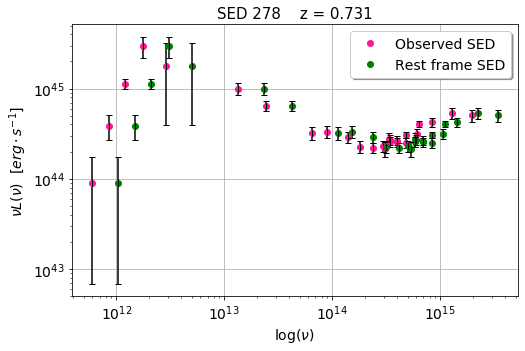

In [19]:
fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
plt.loglog(f_obs, flux,color = 'deeppink', marker = 'o', linestyle = '', label = 'Observed SED')
(_, caps, _) = plt.errorbar(f_obs,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.loglog(f_rest, flux ,color = 'green', marker = 'o', linestyle = '', label = 'Rest frame SED')
(_, caps, _) = plt.errorbar(f_rest,  flux, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.grid() 
plt.title('SED 278    z = ' + str(z), fontsize = 15)
plt.legend(fontsize = 14, shadow = True)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

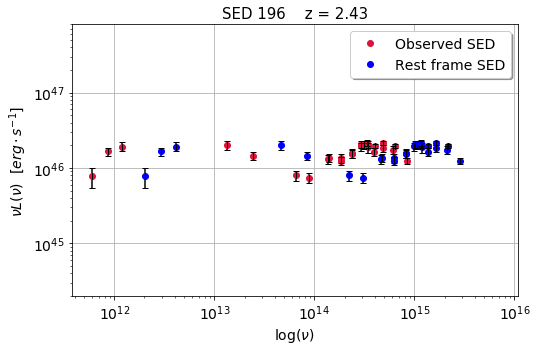

In [20]:
#Observed
z2 = 2.43                                                    # Redshift

f_obs = [(3*10**8)/(i*10**(-10)) for i in l_c]               # Observed frequency [Hz]
data2_Jy = SED2[1, 2::2]*u.Jy*1e-3                           # Intensity [Jy] 
data2 = data2_Jy.to(u.erg/u.s/(u.cm)**2 /u.Hz).value         # Intensity [erg s⁻¹ cm⁻² Hz⁻¹]
D_L2 = cosmo.luminosity_distance(z2).to(u.cm).value           # Relation distance-luminosity
flux2 =  f_obs*data2*4*np.pi*(D_L2)**2                         # Flux [erg s⁻¹]

# Uncertainty [erg s⁻¹]
error2 = f_obs*(SED2[1, 3::2]*u.Jy*1e-3).to(u.erg/u.s/(u.cm)**2 /u.Hz).value*4*np.pi*(D_L2)**2 

# Rest frame frequency [Hz] 
f_rest = [i*(1+z2) for i in f_obs]  


fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
plt.loglog(f_obs, flux2,color = 'crimson', marker = 'o', linestyle = '', label = 'Observed SED')
(_, caps, _) = plt.errorbar(f_obs,  flux2, yerr=  error2, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.loglog(f_rest, flux2 ,color = 'blue', marker = 'o', linestyle = '', label = 'Rest frame SED')
(_, caps, _) = plt.errorbar(f_rest,  flux2, yerr=  error2, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.grid() 
plt.title('SED 196    z = ' + str(z2), fontsize = 15)
plt.legend(fontsize = 14, shadow = True)
plt.ylim(2*1e44, 8*1e47)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()


### Output

Now we present the plot of the parameter values for different percentiles: 2.5, 16, 50, 84 and 97.5. The parameters inferred from the SED fit are: metallicity, exponential decay time, galaxy age, galaxy reddening, dust fraction in starburst, PAH fraction in starburst, column density, BBB reddening, normalisation parameters, absolute magnitude of the galaxy, star formation rate (optical), luminosity of: IR component, BBB, BBB reddened, galaxy, torus and starburst; star formation rate (IR) and likehood (?).

In [21]:
par278 = pd.read_csv("Examples/parameter_outvalues_278.0.txt", delim_whitespace=True, decimal=".", skiprows = 3)

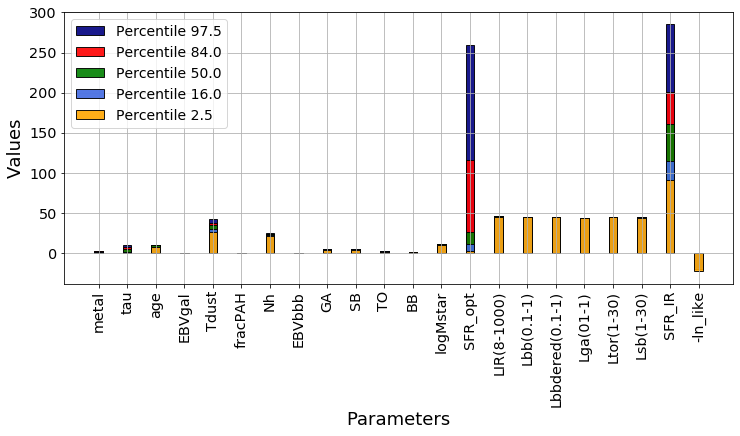

In [22]:
parameters = par278.columns

fig=plt.figure(figsize=(12,5))
plt.xlabel('Parameters', linespacing=1, fontsize = 18)
plt.ylabel('Values', linespacing=1, fontsize = 18)

#Different bars for different percentiles
plt.bar(parameters,par278.iloc[4, :],color='navy',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 97.5')
plt.bar(parameters,par278.iloc[3, :],color='red',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 84.0')
plt.bar(parameters,par278.iloc[2, :],color='green',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 50.0')
plt.bar(parameters,par278.iloc[1, :],color='royalblue',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 16.0')
plt.bar(parameters,par278.iloc[0, :],color='orange',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 2.5')
plt.xticks(rotation=90)
plt.xticks(size = 'x-large')
plt.yticks(size = 'x-large')

plt.legend(loc=2, prop={'size': 14})
plt.grid(True)

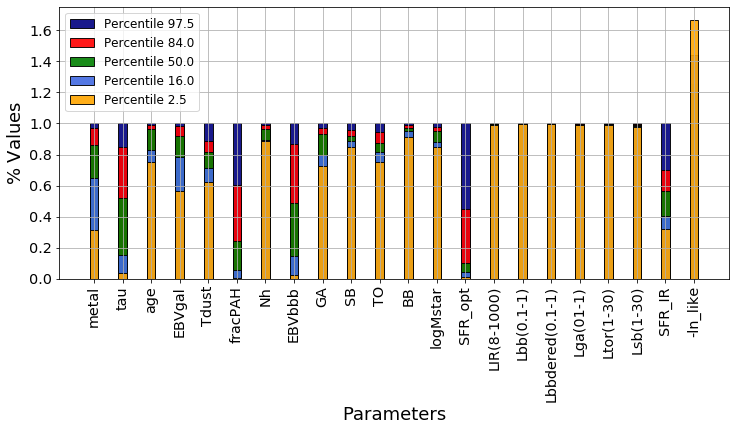

In [23]:
parameters = par278.columns

fig=plt.figure(figsize=(12,5))
plt.xlabel('Parameters', linespacing=1, fontsize = 18)
plt.ylabel(r'$\%$ Values', linespacing=1, fontsize = 18)

#Different bars for different percentiles
plt.bar(parameters,par278.iloc[4, :]/par278.iloc[4, :],color='navy',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 97.5')
plt.bar(parameters,par278.iloc[3, :]/par278.iloc[4, :],color='red',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 84.0')
plt.bar(parameters,par278.iloc[2, :]/par278.iloc[4, :],color='green',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 50.0')
plt.bar(parameters,par278.iloc[1, :]/par278.iloc[4, :],color='royalblue',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 16.0')
plt.bar(parameters,par278.iloc[0, :]/par278.iloc[4, :],color='orange',alpha=0.9, edgecolor = 'black', width=0.3, label='Percentile 2.5')
plt.xticks(rotation=90)
plt.xticks(size = 'x-large')
plt.yticks(size = 'x-large')

plt.legend(loc=2, prop={'size': 12})
plt.grid(True)

In [24]:
SED278 = pd.read_csv("Examples/output_SEDs_278.0.txt", sep = ' ', decimal=".", skiprows = 0)
SED278 = SED278.astype(float)

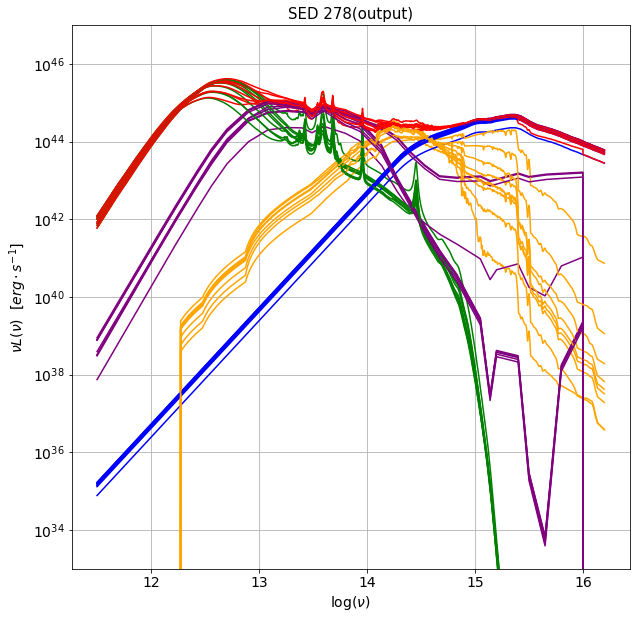

In [25]:
fig = plt.figure(figsize=(10, 10))
plt.ylabel(r'$\nu L(\nu)$  $[erg \cdot s^{-1}]$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 

curvas = 9
for i in range(0, curvas):
    log_f = SED278.iloc[:, 0]        # Log frequency [Hz]
    SB = SED278.iloc[:, 1+i]         # Starburst
    BB = SED278.iloc[:, 11+i]        # Blue bump
    GA = SED278.iloc[:, 21+i]        # Galaxy
    TO = SED278.iloc[:, 31+i]        # Torus
    TOTAL = SED278.iloc[:, 41+i]     # Total
    BB_dr = SED278.iloc[:, 51+i]     # BB dereddened
    
    # OBSERVED SED
    plt.semilogy(log_f, SB, marker = '', color = 'green', linestyle = '-', label = 'SB')
    plt.semilogy(log_f, BB, marker = '', color = 'blue', linestyle = '-', label = 'BB')
    plt.semilogy(log_f, GA, marker = '', color = 'orange', linestyle = '-', label = 'GA')
    plt.semilogy(log_f, TO, marker = '', color = 'purple', linestyle = '-', label = 'TO')
    plt.semilogy(log_f, TOTAL, marker = '', color = 'red', linestyle = '-', label = 'TOTAL')
    #plt.semilogy(log_f, BB_dr, marker = '', color = 'c', linestyle = '-', label = 'BB_dr')
    
plt.grid() 
plt.title('SED 278(output)', fontsize = 15)
#plt.legend(fontsize = 10, shadow = True, loc=8)
plt.ylim(1e33, 1e47)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Run options

You can:
- To choose the number of cpus to multiprocessing
- To run the code for a specific single source
- To create independent model dictionaries for each source
- To overwrite model files

<img src="Examples/Run_options.png" width="850">

## Independent vs non-independent model dictionaries

It is important to create one model dictionary per source according to the redshift of each one. If a global model dictionary is used, the contributions of each components are differents and therefore the physical properties of the active galaxy.

<table><tr><td><img src="Examples/SED_196_i.png" width="870"></td><td><img src="Examples/SED_196_ni.png" width="840"></td></tr></table>